In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
from algorithms import fixed_bitwidth
from model_gen import inception_cnn
from algorithms.optimized_search import OptimizedSearch

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
import pickle

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


## Dependent Optimized Search quantization

In [2]:
input_shape = (96, 96, 1)
num_outputs = 10 # number of classes
path_trained_weights = 'C:/Users/320060820/experiments/test_models/mnist_df/inception_v3_model_batchnorm_w.h5'
output_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/DF MNIST/'
name = 'mnist_df'

from test_models.mnist_df import data
_, test_data = data.get_data()

model_arch = inception_cnn.InceptionCNN(input_shape, num_outputs, dropout=False, 
                                        pool_layer_type='average', path_trained_weights=path_trained_weights)
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]
print(float_model_acc)

Instructions for updating:
Colocations handled automatically by placer.
0.9808


In [7]:
layer_num = [1, 5, 3, 8, 2, 6, 4, 7, 12, 10, 15, 9, 13, 11, 14, 19, 17, 22, 16, 20, 18, 21]
layer_names = [f'conv2d_{i}' for i in layer_num] + ['binary']

['conv2d_1',
 'conv2d_5',
 'conv2d_3',
 'conv2d_8',
 'conv2d_2',
 'conv2d_6',
 'conv2d_4',
 'conv2d_7',
 'conv2d_12',
 'conv2d_10',
 'conv2d_15',
 'conv2d_9',
 'conv2d_13',
 'conv2d_11',
 'conv2d_14',
 'conv2d_19',
 'conv2d_17',
 'conv2d_22',
 'conv2d_16',
 'conv2d_20',
 'conv2d_18',
 'conv2d_21',
 'binary']

### Function design for allocating accuracy drops per layer

In [8]:
total_acc_drop = 0.005
# Functions
# x: layer index
# n: total accuracy drop
# s: scale/number of layers
linear = lambda x, n, s: n/s * x

In [13]:
start_bw = 8
w_scores = {}
opt_params_weights = {}
acc_drop_w = {}

In [14]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
w_scores, opt_params_weights, acc_drop_w = opts.run('weights', start_bw = start_bw)

{'conv2d_1': [8, 7], 'conv2d_5': [8, 6], 'conv2d_3': [8, 6], 'conv2d_6': [8, 7], 'conv2d_2': [8, 6], 'conv2d_4': [8, 7], 'conv2d_7': [8, 7], 'conv2d_8': [8, 7], 'conv2d_12': [8, 6], 'conv2d_10': [8, 7], 'conv2d_13': [8, 7], 'conv2d_9': [8, 7], 'conv2d_11': [8, 7], 'conv2d_14': [8, 7], 'conv2d_15': [8, 7], 'conv2d_19': [8, 6], 'conv2d_17': [8, 6], 'conv2d_20': [8, 6], 'conv2d_16': [8, 7], 'conv2d_18': [8, 6], 'conv2d_21': [8, 6], 'conv2d_22': [8, 7], 'binary': [8, 6]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer conv2d_1
(5, 4) (5, 5) 0.000204
Chosen:  (5, 5)
After quantizing layer conv2d_1 | Measured accuracy drop -0.000612 | Acceptable accuracy drop: 0.000217
Quantizing layer conv2d_5
(3, 2) (4, 3) 0.000204
Chosen:  (3, 2)
After quantizing layer conv2d_5 | Measured accuracy drop -0.000612 | Acceptable accuracy drop: 0.000435
Quantizing layer conv2d_3
(3, 2) (4, 2) 0.000510
Chosen:  (3, 2)
After quantizing layer conv2d_3 | Measured 

Floating point model accuracy: 98.080 %
Quantized model accuracy: 97.740 %
Accuracy drop of 0.347 %


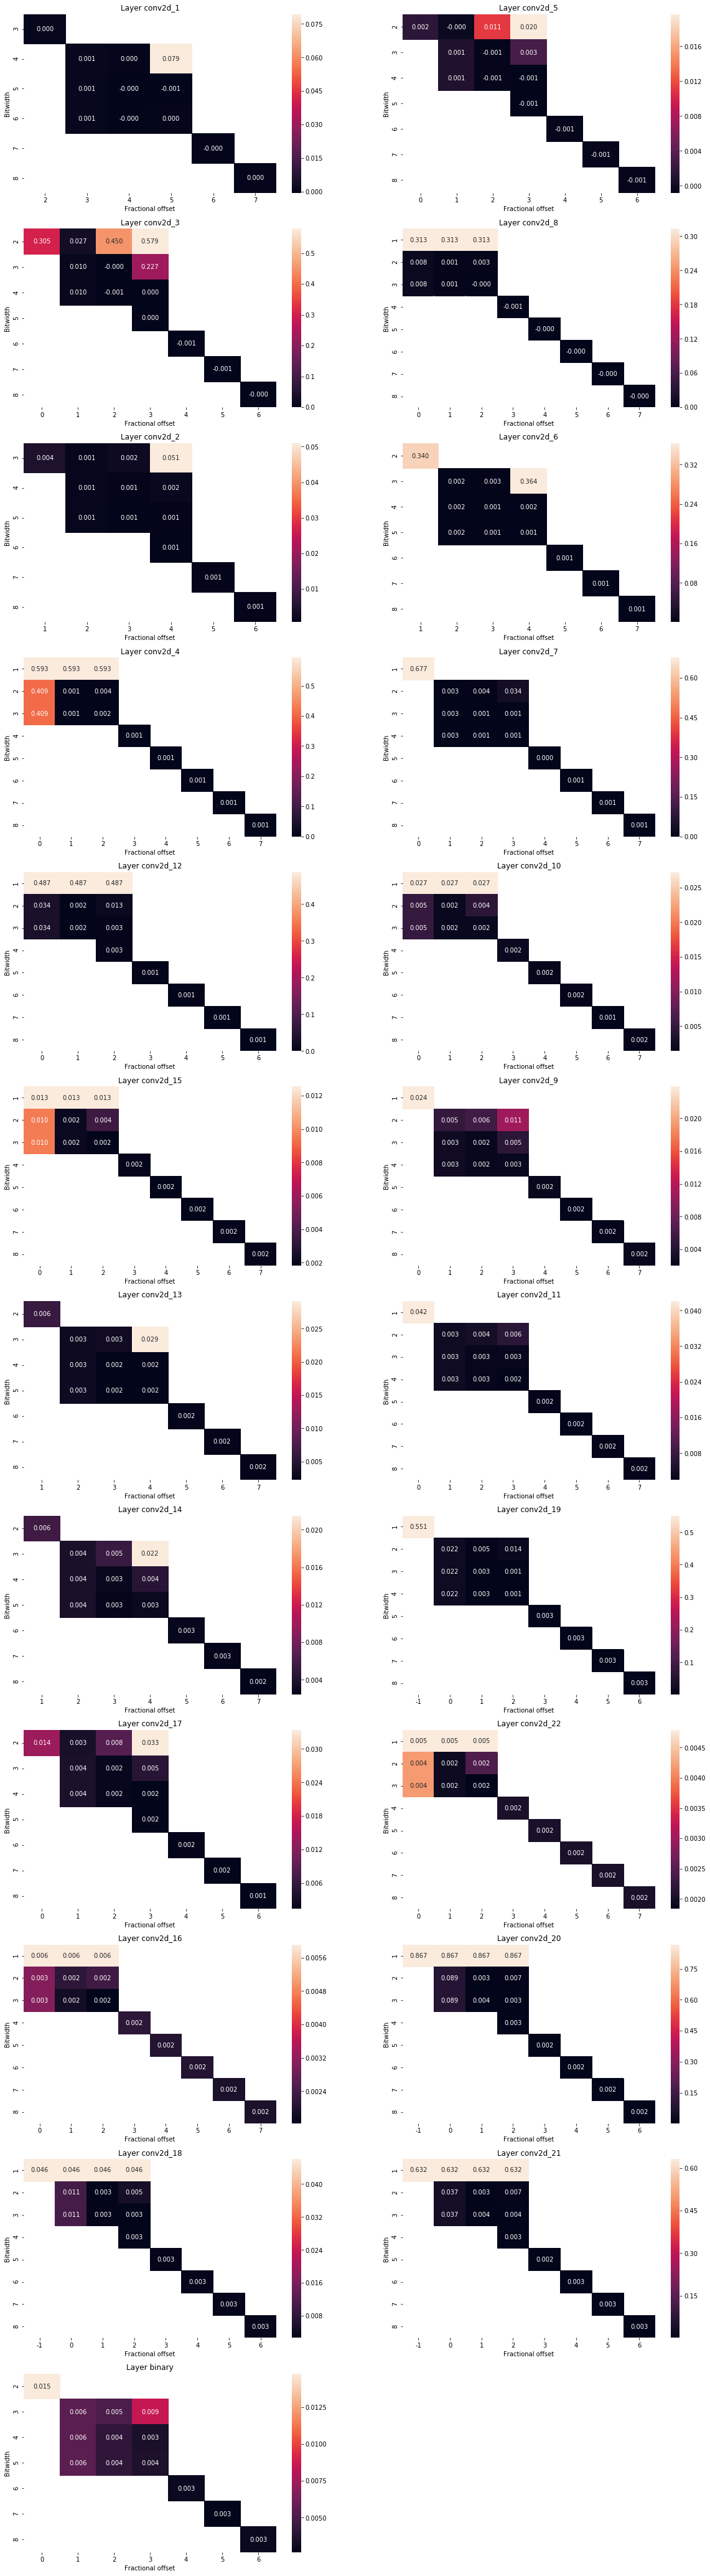

In [17]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights)
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(w_scores, 12, 2, (20, 75))

In [21]:
with open(output_path + 'f_w_scores.p', 'wb') as f:
    pickle.dump(w_scores, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(output_path + 'f_opt_params_w.p', 'wb') as f:
    pickle.dump(opt_params_weights, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(output_path + 'f_acc_drop_w.p', 'wb') as f:
    pickle.dump(acc_drop_w, f, protocol=pickle.HIGHEST_PROTOCOL)

## Observing results for the types of allocations

No handles with labels found to put in legend.


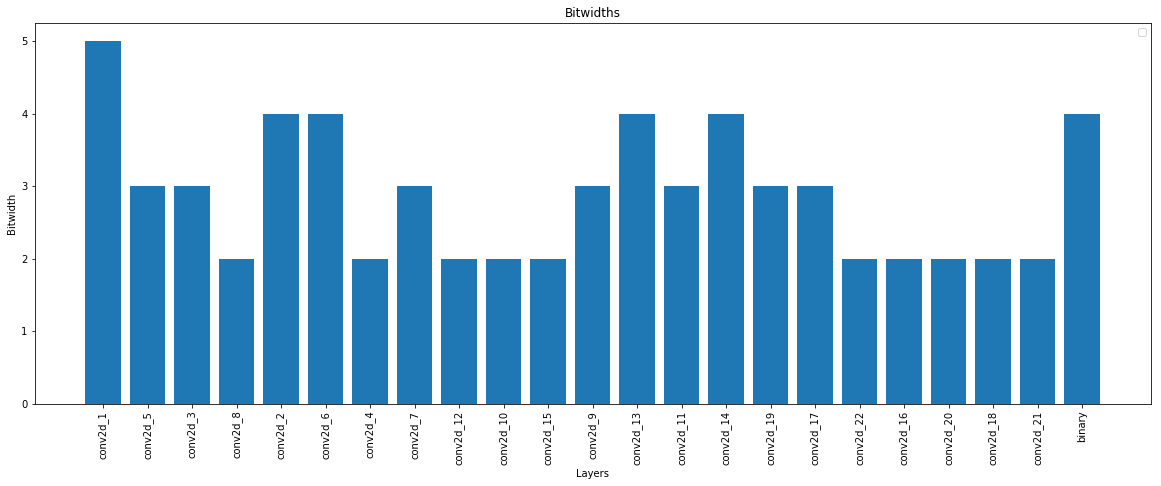

In [23]:
plt.figure(figsize=(20, 7))
x = np.arange(1, len(layer_names) + 1, 1)
bw = [opt_params_weights[layer][0] for layer in opt_params_weights]
plt.bar(x, bw);
plt.xticks(x, layer_names, rotation='vertical')
plt.title('Bitwidths');
plt.xlabel('Layers');
plt.ylabel('Bitwidth');

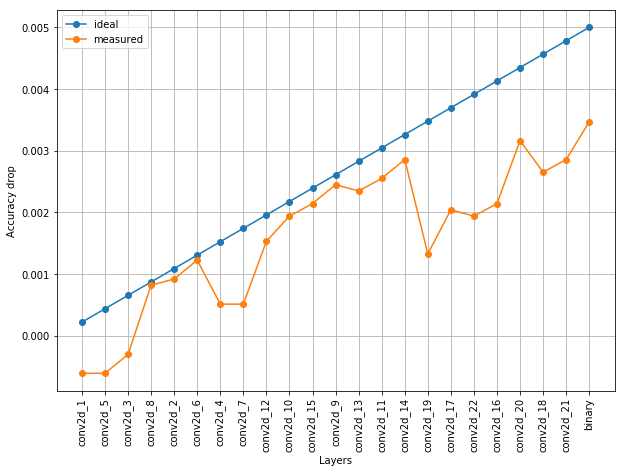

In [26]:
x = np.arange(1, len(layer_names) + 1, 1)
num_layers = len(x)
n = 0.005 # loss of 0.5%
y = linear(x, n, num_layers)

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-', label='ideal');
plt.plot(x, acc_drop_w.values(), 'o-', label='measured');
plt.xticks(x, layer_names, rotation='vertical')
plt.xlabel('Layers');
plt.ylabel('Accuracy drop');
plt.grid();
plt.legend();

In [27]:
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())

In [ ]:
model_obj.model.layers.name == 

In [33]:
num_params = []
for layer in layer_names:
    for n in model_obj.model.layers:
        if n.name == layer:
            w = n.get_weights()[0]
            num_weights = len(w.flatten())
            print(layer, num_weights)
            num_params.append(num_weights)
            break

conv2d_1 180
conv2d_5 320
conv2d_3 320
conv2d_8 320
conv2d_2 320
conv2d_6 2304
conv2d_4 2304
conv2d_7 2304
conv2d_12 2048
conv2d_10 2048
conv2d_15 2048
conv2d_9 2048
conv2d_13 9216
conv2d_11 9216
conv2d_14 9216
conv2d_19 8192
conv2d_17 8192
conv2d_22 8192
conv2d_16 8192
conv2d_20 36864
conv2d_18 36864
conv2d_21 36864
binary 2560


In [36]:
bw = [opt_params_weights[layer][0] for layer in opt_params_weights]
memory_bits = sum([bw[i] * num_params[i] for i in range(len(layer_names))])
memory_fixed_bw = sum([4 * num_params[i] for i in range(len(layer_names))])
memory_consumption_MB = memory_bits/(8*1024**2)
memory_fixed_bw_MB = memory_fixed_bw/(8*1024**2)
print(memory_consumption_MB, memory_fixed_bw_MB)

0.0546727180480957 0.09066200256347656


# Activations

In [37]:
start_bw = 16
a_scores = {}
opt_params_act = {}
acc_drop_a = {}

In [38]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
a_scores, opt_params_act, acc_drop_a = opts.run('activations', start_bw = start_bw)

{'conv2d_1': [16, 14], 'conv2d_5': [16, 11], 'conv2d_3': [16, 11], 'conv2d_6': [16, 9], 'conv2d_2': [16, 11], 'conv2d_4': [16, 9], 'conv2d_7': [16, 9], 'conv2d_8': [16, 11], 'conv2d_12': [16, 10], 'conv2d_10': [16, 10], 'conv2d_13': [16, 8], 'conv2d_9': [16, 10], 'conv2d_11': [16, 8], 'conv2d_14': [16, 8], 'conv2d_15': [16, 10], 'conv2d_19': [16, 9], 'conv2d_17': [16, 9], 'conv2d_20': [16, 8], 'conv2d_16': [16, 9], 'conv2d_18': [16, 8], 'conv2d_21': [16, 8], 'conv2d_22': [16, 10], 'binary': [16, 9]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer conv2d_1
(11, 9) (12, 10) 0.000102
Chosen:  (11, 9)
After quantizing layer conv2d_1 | Measured accuracy drop 0.000000 | Acceptable accuracy drop: 0.000217
Quantizing layer conv2d_5
(4, -1) (4, 0) 0.000204
Chosen:  (4, 0)
After quantizing layer conv2d_5 | Measured accuracy drop 0.000102 | Acceptable accuracy drop: 0.000435
Quantizing layer conv2d_3
(4, 0) (4, 0) 0.000000
Chosen:  (4, 0)
After q

Floating point model accuracy: 98.080 %
Quantized model accuracy: 97.640 %
Accuracy drop of 0.449 %


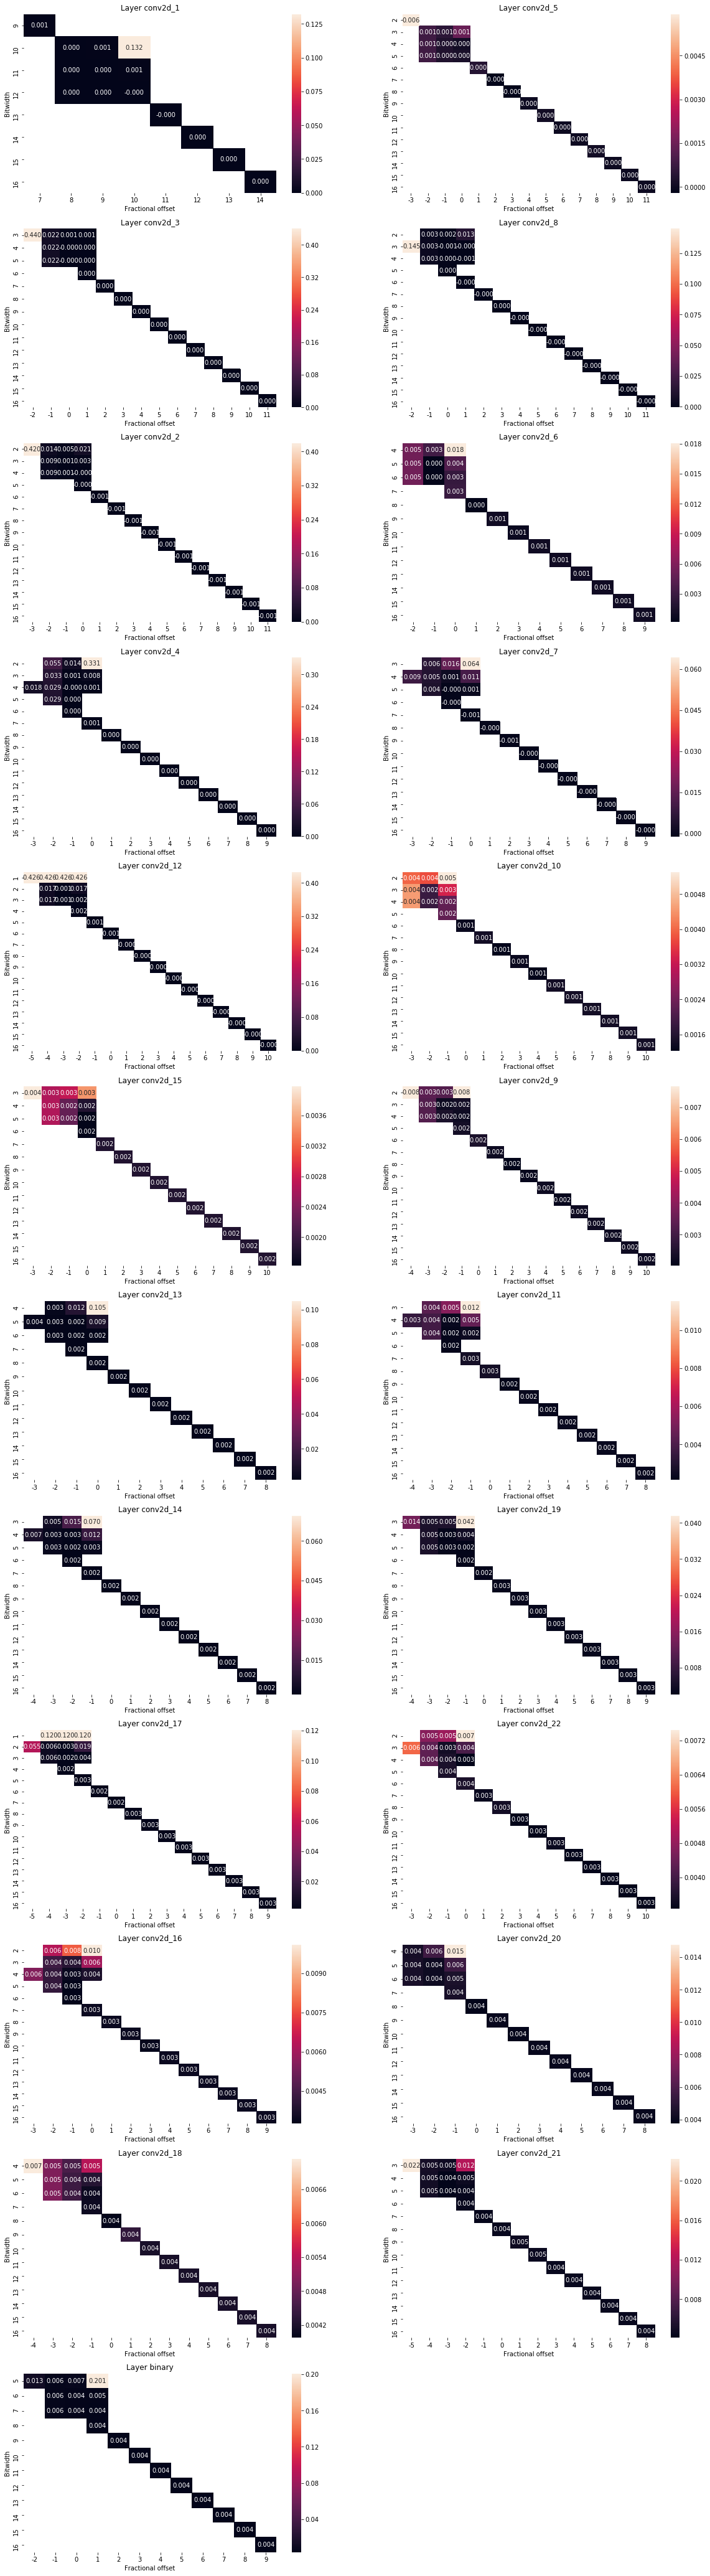

In [39]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act))
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(a_scores, 12, 2, (20, 75))

In [40]:
with open(output_path + 'f_a_scores.p', 'wb') as f:
    pickle.dump(a_scores, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(output_path + 'f_opt_params_a.p', 'wb') as f:
    pickle.dump(opt_params_act, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(output_path + 'f_acc_drop_a.p', 'wb') as f:
    pickle.dump(acc_drop_a, f, protocol=pickle.HIGHEST_PROTOCOL)

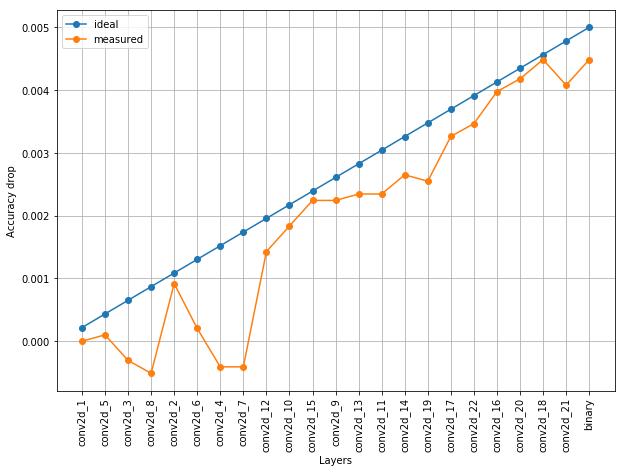

In [41]:
x = np.arange(1, len(layer_names) + 1, 1)
num_layers = len(x)
n = 0.005 # loss of 0.5%
y = linear(x, n, num_layers)

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-', label='ideal');
plt.plot(x, acc_drop_a.values(), 'o-', label='measured');
plt.xticks(x, layer_names, rotation='vertical')
plt.xlabel('Layers');
plt.ylabel('Accuracy drop');
plt.grid();
plt.legend();

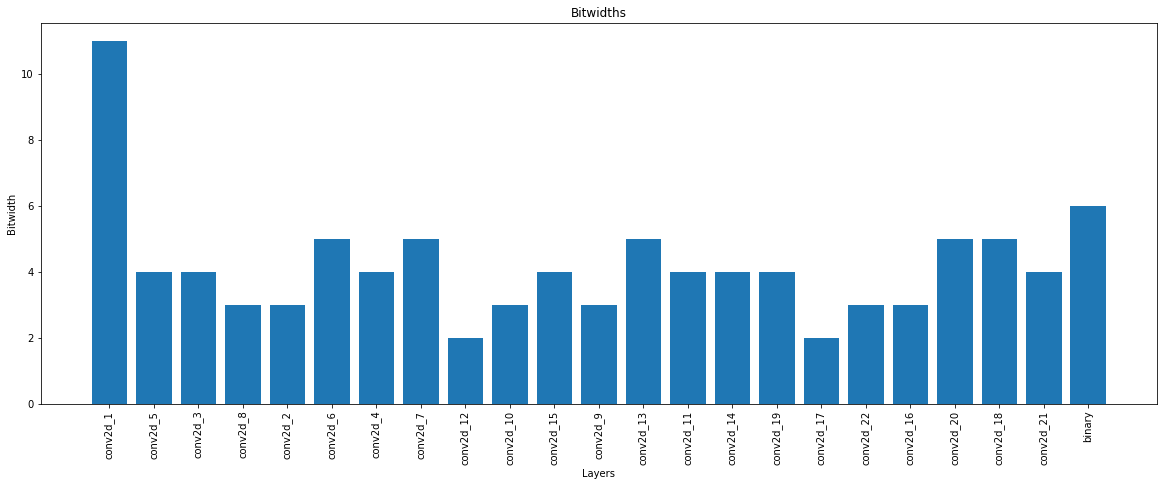

In [42]:
plt.figure(figsize=(20, 7))
x = np.arange(1, len(layer_names) + 1, 1)
bw = [opt_params_act[layer][0] for layer in opt_params_act]
plt.bar(x, bw);
plt.xticks(x, layer_names, rotation='vertical')
plt.title('Bitwidths');
plt.xlabel('Layers');
plt.ylabel('Bitwidth');